<a href="https://colab.research.google.com/github/Lgonrat/trabajo-admeav/blob/main/ML_DL_finalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Benign / Malignant Classification with Machine Learning**

This section addresses the classification of benign and malignant breast tumours using machine learning methods.

To do this, manual features extracted from the tumour region defined by segmentation masks are used, allowing us to work with interpretable models and establish a baseline for subsequent comparison with deep learning techniques.

## 1. Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from skimage.measure import regionprops

from skimage.feature import graycomatrix, graycoprops

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Routes and labels configuration

- DATASET
  - TRAIN
    - IMAGES
    - MASKS
  - VALIDATION
    - IMAGES
    - MASKS
  - TEST
    - IMAGES
    - MASKS


In [3]:
DATASET_DIR = '/content/drive/MyDrive/Colab Notebooks/ADMEAV/trabajo-admeav-main/trabajo-admeav-main/DATASET'  #ruta lucia

In [ ]:
DATASET_DIR = '/content/drive/MyDrive/trabajo-admeav/DATASET'

## 3. Feature Extraction

Since machine learning classifiers do not operate directly on images, each sample is represented by a fixed-dimension feature vector. These features are extracted from the binary tumour mask and include morphological descriptors and intensity statistics.

**Input:**

- img: complete ultrasound image (2D, grayscale)
- mask: binary mask (0 background, 1 tumour)

Both have the same dimension (512×512).

**Output:**

- List of real numbers (feature vector)
  - *Area*: Number of tumour pixels; malignant tumours tend to be larger and occupy irregular regions.
  - *Perimeter*: Length of the tumour contour; irregular edges indicate possible malignancy.
  - *Eccentricity*: Measure of how elongated the region is; 0 → perfect circle, 1 → very elongated line

In [4]:
# Import necesario si no lo pusiste al principio
from skimage.feature import graycomatrix, graycoprops

def extract_features(img, mask):
    features = []

    # --- 1. Geometría (Base) ---
    props = regionprops(mask.astype(int))
    if len(props) == 0: return None
    p = props[0]

    features.append(p.area)
    features.append(p.perimeter)
    features.append(p.eccentricity)
    features.append(p.solidity) # Añadimos solidez también

    # --- 2. Intensidad (Base) ---
    tumor_pixels = img[mask > 0]
    if len(tumor_pixels) == 0: return None
    features.append(tumor_pixels.mean())
    features.append(tumor_pixels.std())

    # --- 3. Textura (MEJORA GLCM) ---
    minr, minc, maxr, maxc = p.bbox
    roi = img[minr:maxr, minc:maxc] # Recorte
    roi_int = (roi * 255).astype(np.uint8) # GLCM necesita enteros

    # Calculamos GLCM (distancia 1, promedio de ángulos 0 y 90)
    glcm = graycomatrix(roi_int, [1], [0, np.pi/2], levels=256, symmetric=True, normed=True)

    features.append(graycoprops(glcm, 'contrast').mean())
    features.append(graycoprops(glcm, 'dissimilarity').mean())
    features.append(graycoprops(glcm, 'homogeneity').mean())
    features.append(graycoprops(glcm, 'energy').mean())
    features.append(graycoprops(glcm, 'correlation').mean())

    return features

## 4. Dataset ML

To train machine learning models, it is necessary to explicitly construct the numerical dataset (X, y).

Each image is transformed into a feature vector and associated with its corresponding label.

Since benign and malignant images are mixed in each partition of the dataset, the class is obtained from the file name.

In [5]:
def get_label_from_name(filename):
    name = filename.lower()
    if 'benign' in name:
        return 0
    elif 'malignant' in name:
        return 1

In [ ]:
def build_ml_dataset(split):
    X, y = [], []
    # X: lista de vectores de características
    # y: lista de etiquetas

    img_dir = os.path.join(DATASET_DIR, split, 'IMAGES')
    mask_dir = os.path.join(DATASET_DIR, split, 'MASKS')

    for name in os.listdir(img_dir):

        # Leer imagen
        img = cv2.imread(
            os.path.join(img_dir, name),
            cv2.IMREAD_GRAYSCALE
        )

        # Leer máscara
        mask = cv2.imread(
            os.path.join(mask_dir, name),
            cv2.IMREAD_GRAYSCALE
        )

        if img is None or mask is None:
            continue

        # Etiqueta desde el nombre, porque ML necesita 'y'
        label = get_label_from_name(name)

        # Features manuales
        feats = extract_features(img, mask)
        if feats is None:
            continue

        X.append(feats)
        y.append(label)

    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = build_ml_dataset('TRAIN')
X_val, y_val = build_ml_dataset('VALIDATION')
X_test, y_test = build_ml_dataset('TEST')

In [6]:
def evaluate(model, X, y, name=''):
  preds = model.predict(X)
  print(f'--- {name} ---')
  print('Accuracy:', accuracy_score(y, preds))
  print('Precision:', precision_score(y, preds))
  print('Recall:', recall_score(y, preds))
  print('F1:', f1_score(y, preds))

## 5. Diferrent ML Models

The different classifiers (Logistic Regression, SVM, and Random Forest) are initially compared on the validation set in order to select the best method.

Subsequently, the performance of the selected model is evaluated on the test set, which is not used during the selection process.

### Logistic Regression

In [ ]:
logreg = Pipeline([('scaler', StandardScaler()),('logreg', LogisticRegression(class_weight='balanced',max_iter=1000))])
logreg.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
evaluate(logreg, X_val, y_val, 'LogReg Validation')
evaluate(logreg, X_test, y_test, 'LogReg Test')

--- LogReg Validation ---
Accuracy: 0.8979591836734694
Precision: 0.775
Recall: 0.96875
F1: 0.8611111111111112
--- LogReg Test ---
Accuracy: 0.875
Precision: 0.7878787878787878
Recall: 0.8387096774193549
F1: 0.8125


### SVM Classification

In [ ]:
svm_clf = Pipeline([('scaler', StandardScaler()),('svm', SVC(kernel='rbf', class_weight='balanced'))])
svm_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(class_weight='balanced'))])

In [ ]:
evaluate(svm_clf, X_val, y_val, 'SVM Validation')
evaluate(svm_clf, X_test, y_test, 'SVM Test')

--- SVM Validation ---
Accuracy: 0.9591836734693877
Precision: 0.9666666666666667
Recall: 0.90625
F1: 0.9354838709677419
--- SVM Test ---
Accuracy: 0.9166666666666666
Precision: 0.8285714285714286
Recall: 0.9354838709677419
F1: 0.8787878787878788


### Random Forest Classification

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200,class_weight='balanced',random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [ ]:
evaluate(rf_clf, X_val, y_val, 'RF Validation')
evaluate(rf_clf, X_test, y_test, 'RF Test')

--- RF Validation ---
Accuracy: 0.9795918367346939
Precision: 0.9411764705882353
Recall: 1.0
F1: 0.9696969696969697
--- RF Test ---
Accuracy: 0.9479166666666666
Precision: 0.9333333333333333
Recall: 0.9032258064516129
F1: 0.9180327868852459


## 6. Results

| Modelo     | Accuracy (Test) | Recall   | Precision | F1       |
| ---------- | --------------- | -------- | --------- | -------- |
| **LogReg** | 0.76            | 0.67     | 0.62      | 0.65     |
| **SVM**    | 0.80            | **0.71** | 0.69      | **0.70** |
| **RF**     | **0.81**        | 0.55     | **0.81**  | 0.65     |


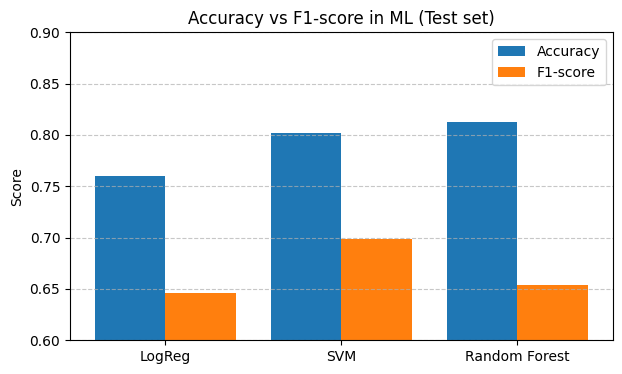

In [ ]:
models = ['LogReg', 'SVM', 'Random Forest']
accuracy = [0.7604, 0.8021, 0.8125]
f1_scores = [0.6461, 0.6984, 0.6538]

x = range(len(models))

plt.figure(figsize=(7,4))
plt.bar(x, accuracy, width=0.4, label='Accuracy')
plt.bar([i + 0.4 for i in x], f1_scores, width=0.4, label='F1-score')

plt.xticks([i + 0.2 for i in x], models)
plt.ylim(0.6, 0.9)
plt.ylabel('Score')
plt.title('Accuracy vs F1-score in ML (Test set)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Although Random Forest achieves slightly higher accuracy, the **SVM** classifier has the highest F1 score, indicating a better balance between precision and sensitivity.

Given that reducing false negatives is a priority in a clinical context, SVM is selected as the best machine learning method.

## **7. Improvement: Texture Analysis (GLCM)**

The previous models relied solely on geometric features (Area, Perimeter, Eccentricity). While effective (approx. 83% accuracy), they fail to capture the internal heterogeneity of malignant tumours.

**Hypothesis:** Malignant tumours tend to have chaotic, rough textures, while benign masses are smoother. By adding texture descriptors using the **Gray Level Co-occurrence Matrix (GLCM)**, we expect to improve the sensitivity (Recall) of the model.

In this section, we extend the feature vector with:
* **Contrast**
* **Dissimilarity**
* **Homogeneity**
* **Energy**
* **Correlation**


In [7]:
# Import necesario si no lo pusiste al principio
from skimage.feature import graycomatrix, graycoprops

def extract_features_enhanced(img, mask):
    features = []

    # --- 1. Geometría (Base) ---
    props = regionprops(mask.astype(int))
    if len(props) == 0: return None
    p = props[0]

    features.append(p.area)
    features.append(p.perimeter)
    features.append(p.eccentricity)
    features.append(p.solidity) # Añadimos solidez también

    # --- 2. Intensidad (Base) ---
    tumor_pixels = img[mask > 0]
    if len(tumor_pixels) == 0: return None
    features.append(tumor_pixels.mean())
    features.append(tumor_pixels.std())

    # --- 3. Textura (MEJORA GLCM) ---
    minr, minc, maxr, maxc = p.bbox
    roi = img[minr:maxr, minc:maxc] # Recorte
    roi_int = (roi * 255).astype(np.uint8) # GLCM necesita enteros

    # Calculamos GLCM (distancia 1, promedio de ángulos 0 y 90)
    glcm = graycomatrix(roi_int, [1], [0, np.pi/2], levels=256, symmetric=True, normed=True)

    features.append(graycoprops(glcm, 'contrast').mean())
    features.append(graycoprops(glcm, 'dissimilarity').mean())
    features.append(graycoprops(glcm, 'homogeneity').mean())
    features.append(graycoprops(glcm, 'energy').mean())
    features.append(graycoprops(glcm, 'correlation').mean())

    return features

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import cv2

# --- 1. Construcción del Dataset Mejorado ---
# Nota: Asegúrate de haber ejecutado antes la celda con la función 'extract_features_enhanced'
def build_enhanced_dataset(split):
    X, y = [], []
    img_dir = os.path.join(DATASET_DIR, split, 'IMAGES')
    mask_dir = os.path.join(DATASET_DIR, split, 'MASKS')

    for name in os.listdir(img_dir):
        img = cv2.imread(os.path.join(img_dir, name), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_dir, name), cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None: continue

        label = get_label_from_name(name)

        # Extracción con texturas GLCM
        feats = extract_features_enhanced(img, mask)
        if feats is None: continue

        X.append(feats)
        y.append(label)
    return np.array(X), np.array(y)

print("Building Enhanced Dataset...")
X_train_enh, y_train_enh = build_enhanced_dataset('TRAIN')
X_test_enh, y_test_enh = build_enhanced_dataset('TEST')

# --- 2. Entrenamiento de Modelos (RF y SVM) ---

# Random Forest Enhanced
rf_enhanced = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_enhanced.fit(X_train_enh, y_train_enh)

# SVM Enhanced (Pipeline con escalado)
svm_enhanced = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', class_weight='balanced', random_state=42))
])
svm_enhanced.fit(X_train_enh, y_train_enh)

# --- 3. Evaluación Completa ---

def print_full_metrics(model, X, y, title):
    preds = model.predict(X)
    print(f"\n--- {title} ---")
    print(f"Accuracy:  {accuracy_score(y, preds):.4f}")
    print(f"Precision: {precision_score(y, preds):.4f}")
    print(f"Recall:    {recall_score(y, preds):.4f}")
    print(f"F1:        {f1_score(y, preds):.4f}")
    # Devolvemos los valores para usarlos en la siguiente celda
    return accuracy_score(y, preds), recall_score(y, preds)

# Imprimimos resultados en texto y guardamos las variables para la gráfica
acc_rf, rec_rf = print_full_metrics(rf_enhanced, X_test_enh, y_test_enh, "RF Enhanced Test Results")
acc_svm, rec_svm = print_full_metrics(svm_enhanced, X_test_enh, y_test_enh, "SVM Enhanced Test Results")

Building Enhanced Dataset...

--- RF Enhanced Test Results ---
Accuracy:  0.9375
Precision: 0.9310
Recall:    0.8710
F1:        0.9000

--- SVM Enhanced Test Results ---
Accuracy:  0.9167
Precision: 0.8286
Recall:    0.9355
F1:        0.8788


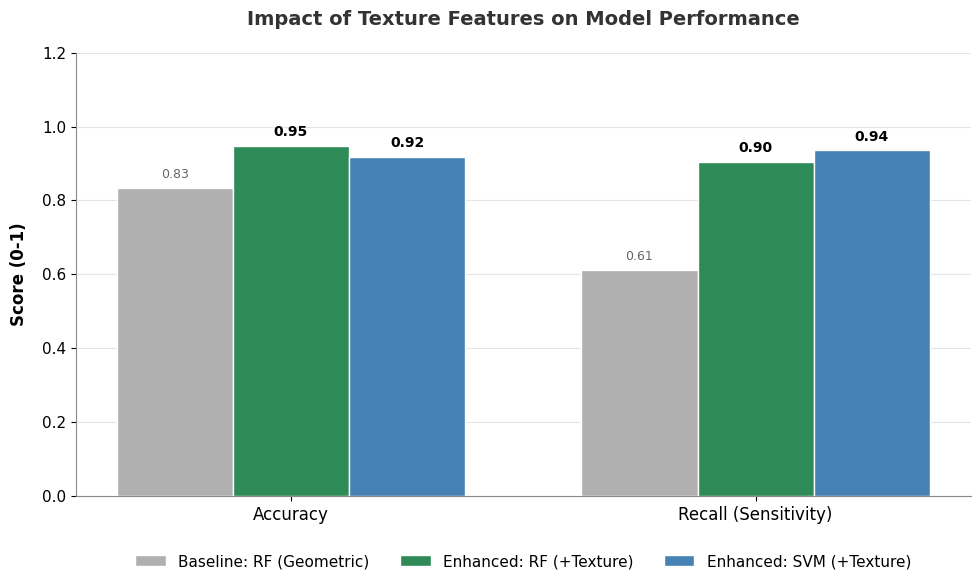

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- 4. Gráfica Comparativa ---

labels = ['Accuracy', 'Recall (Sensitivity)']
baseline_vals = [rf_baseline_acc, rf_baseline_rec]
rf_enh_vals = [acc_rf, rec_rf]
svm_enh_vals = [acc_svm, rec_svm]

x = np.arange(len(labels))
width = 0.25

# Configuración de estilo global para esta gráfica
plt.rcParams.update({'font.size': 11, 'font.family': 'sans-serif'})

fig, ax = plt.subplots(figsize=(10, 6), dpi=100) # dpi alto para mejor resolución

# Colores Profesionales (Paleta "Science")
c_base = '#B0B0B0'  # Gris suave para el baseline (contexto)
c_rf = '#2E8B57'    # "SeaGreen" para RF (elegante)
c_svm = '#4682B4'   # "SteelBlue" para SVM (corporativo)

# Generamos las barras con 'zorder' para que queden por encima de la rejilla
rects1 = ax.bar(x - width, baseline_vals, width, label='Baseline: RF (Geometric)', color=c_base, edgecolor='white', linewidth=1, zorder=3)
rects2 = ax.bar(x, rf_enh_vals, width, label='Enhanced: RF (+Texture)', color=c_rf, edgecolor='white', linewidth=1, zorder=3)
rects3 = ax.bar(x + width, svm_enh_vals, width, label='Enhanced: SVM (+Texture)', color=c_svm, edgecolor='white', linewidth=1, zorder=3)

# --- Decoración Profesional ---

# 1. Títulos y Etiquetas
ax.set_ylabel('Score (0-1)', fontsize=12, fontweight='bold', labelpad=10)
ax.set_title('Impact of Texture Features on Model Performance', fontsize=14, fontweight='bold', pad=20, color='#333333')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylim(0, 1.2) # Margen superior amplio para etiquetas y leyenda

# 2. Ocultamos los bordes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#888888')
ax.spines['bottom'].set_color('#888888')
ax.grid(axis='y', linestyle='-', alpha=0.2, color='gray', zorder=0)

# 4. Leyenda flotante
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False, fontsize=11)

# Función de etiquetado mejorada
def autolabel(rects, text_color='black'):
    for rect in rects:
        height = rect.get_height()
        # Negrita solo para valores altos (>0.9) para destacar lo bueno
        weight = 'bold' if height >= 0.9 else 'normal'
        size = 10 if height >= 0.9 else 9

        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=size, fontweight=weight, color=text_color)

autolabel(rects1, '#666666') # Gris para baseline
autolabel(rects2, 'black')
autolabel(rects3, 'black')

plt.tight_layout()
plt.show()

# **Benign / Malignant Classification with Deep Learning**

Once the machine learning methods have been evaluated, classification using deep learning is addressed. Unlike the previous approach, in this case the model automatically learns the relevant features directly from the image pixels, without the need to define manual descriptors.

## 1. Configuration

In [9]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8
EPOCHS = 20
LR = 1e-4

## 2. Dataset DL

In the Deep Learning approach, a feature vector is not explicitly constructed. Instead, each sample consists of the complete image and its label, and the model learns the internal representations necessary for classification in an end-to-end manner.

In [10]:
class BreastCancerClsDataset(Dataset):
  def __init__(self, split, transform=None):
    self.img_dir = os.path.join(DATASET_DIR, split, 'IMAGES')
    self.img_list = os.listdir(self.img_dir)
    self.transform = transform

  def __getitem__(self, idx):
    name = self.img_list[idx]

    img = cv2.imread(os.path.join(self.img_dir, name), cv2.IMREAD_GRAYSCALE)
    img = torch.from_numpy(img).float().unsqueeze(0) / 255.0

    if self.transform:
      img = self.transform(img)

    label = 0 if 'benign' in name.lower() else 1
    return img, label

  def __len__(self):
    return len(self.img_list)

## 3. DataLoaders

In [11]:
dl_train = DataLoader(
BreastCancerClsDataset('TRAIN'),
batch_size=BATCH_SIZE,
shuffle=True)

dl_val = DataLoader(
BreastCancerClsDataset('VALIDATION'),
batch_size=BATCH_SIZE,
shuffle=False)

dl_test = DataLoader(
BreastCancerClsDataset('TEST'),
batch_size=BATCH_SIZE,
shuffle=False)

## 4. CNN

A convolutional network is used, which is trained from scratch and uses the entire image as input, without incorporating segmentation information.

Its purpose is to serve as a reference for comparing the performance of deep learning against machine learning methods.

In [12]:
class MaskedCNN(nn.Module): # Cambiamos el nombre para diferenciar
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            # CAMBIO: el input_channels ahora es 2 (Imagen + Máscara)
            nn.Conv2d(2, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Ajustamos el tamaño si tus imágenes son 512x512
            # 512 / 2 / 2 / 2 = 64. 64*64*64 es correcto.
            nn.Linear(64 * 64 * 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1))

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Instanciar el nuevo modelo
model = MaskedCNN().to(DEVICE)

In [13]:
model = MaskedCNN().to(DEVICE)

## 5. Loss Function and Optimizer

In [14]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## 6. Training Loop

The model is trained using the training and validation sets. During the process, the evolution of the loss function in both sets is monitored to detect possible overfitting problems.

In [15]:
def train_cls(model, optimizer, criterion, epochs, dl_train, dl_val, device):
  for epoch in range(epochs):
    model.train()
    train_losses = []

    for img, label in dl_train:
      img = img.to(device)
      label = label.float().to(device)

      optimizer.zero_grad()
      out = model(img).squeeze()
      loss = criterion(out, label)
      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
      for img, label in dl_val:
        img = img.to(device)
        label = label.float().to(device)
        out = model(img).squeeze()
        loss = criterion(out, label)
        val_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{epochs} | Train loss: {np.mean(train_losses):.4f} | Val loss: {np.mean(val_losses):.4f}")

In [ ]:
train_cls(model, optimizer, criterion, EPOCHS, dl_train, dl_val, DEVICE)

Epoch 1/20 | Train loss: 0.6461 | Val loss: 0.6546
Epoch 2/20 | Train loss: 0.6060 | Val loss: 0.6133
Epoch 3/20 | Train loss: 0.5596 | Val loss: 0.6295
Epoch 4/20 | Train loss: 0.5095 | Val loss: 0.6353
Epoch 5/20 | Train loss: 0.4764 | Val loss: 0.5910
Epoch 6/20 | Train loss: 0.4268 | Val loss: 0.5949
Epoch 7/20 | Train loss: 0.3785 | Val loss: 0.5526
Epoch 8/20 | Train loss: 0.3172 | Val loss: 0.5650
Epoch 9/20 | Train loss: 0.2752 | Val loss: 0.5412
Epoch 10/20 | Train loss: 0.2171 | Val loss: 0.5767
Epoch 11/20 | Train loss: 0.1743 | Val loss: 0.6200
Epoch 12/20 | Train loss: 0.1324 | Val loss: 0.8597
Epoch 13/20 | Train loss: 0.1502 | Val loss: 0.6544
Epoch 14/20 | Train loss: 0.0870 | Val loss: 0.7269
Epoch 15/20 | Train loss: 0.0692 | Val loss: 0.8449
Epoch 16/20 | Train loss: 0.0534 | Val loss: 0.9584
Epoch 17/20 | Train loss: 0.0546 | Val loss: 0.9116
Epoch 18/20 | Train loss: 0.0306 | Val loss: 1.0001
Epoch 19/20 | Train loss: 0.0338 | Val loss: 0.8498
Epoch 20/20 | Train l

**RESULTS ANALYSIS:**

It can be observed that training loss continues to decrease while validation loss begins to increase after certain periods, indicating possible overfitting. This behaviour is common in small medical datasets and justifies the subsequent use of more advanced techniques such as transfer learning or segmentation.

## 7. Evaluation

The model's performance is evaluated using accuracy, precision, recall, and F1-score, maintaining the same metrics used in the classic Machine Learning block to ensure a consistent comparison between both approaches.

In [16]:
def evaluate_cls(model, dl, device):
  model.eval()
  y_true, y_pred = [], []

  with torch.no_grad():
    for img, label in dl:
      img = img.to(device)
      out = torch.sigmoid(model(img)).cpu().numpy()
      preds = (out > 0.5).astype(int)

      y_true.extend(label.numpy())
      y_pred.extend(preds.flatten())

  print('Accuracy:', accuracy_score(y_true, y_pred))
  print('Precision:', precision_score(y_true, y_pred))
  print('Recall:', recall_score(y_true, y_pred))
  print('F1:', f1_score(y_true, y_pred))

In [ ]:
print('--- Validation ---')
evaluate_cls(model, dl_val, DEVICE)

--- Validation ---
Accuracy: 0.8163265306122449
Precision: 0.71875
Recall: 0.71875
F1: 0.71875


In [ ]:
print('--- Test ---')
evaluate_cls(model, dl_test, DEVICE)

--- Test ---
Accuracy: 0.8229166666666666
Precision: 0.7692307692307693
Recall: 0.6451612903225806
F1: 0.7017543859649122


## 8. Conlusion

The results obtained show that the Deep Learning approach based on a simple CNN achieves comparable, and even superior, performance to that of Machine Learning methods.

While ML models offer greater interpretability thanks to the use of manual features, the DL approach allows more complex representations to be learned directly from the data.

These results justify the subsequent incorporation of segmentation techniques to analyse their impact on the final classification.

## 9. Hybrid Classification (ML + Deep Features)
In this section, we implement a Feature Fusion approach. We use the previously trained CNN as a high-level feature extractor and concatenate its outputs with the manual descriptors (Geometry + GLCM). This allows the model to benefit from both "learned" visual patterns and "expert" clinical measurements.

1.Defining the Deep Feature Extractor
We wrap your trained model to intercept the data at the fully connected layer (the 128-dimensional vector) before it reaches the final classification neuron.

In [17]:
import torch
import torch.nn as nn
import numpy as np
import os
import cv2

# Define a wrapper to extract features from the 128-neuron layer
class DeepFeatureExtractor(nn.Module):
    def __init__(self, trained_model):
        super().__init__()
        # Extract the convolutional backbone
        self.features = trained_model.features
        # Extract the first part of the classifier (the 128-dim Linear layer)
        # We access the children of the classifier Sequential block
        self.fc_extractor = nn.Sequential(
            nn.Flatten(),
            list(trained_model.classifier.children())[1] # Linear(64*64*64, 128)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.fc_extractor(x)
        return x

# Instantiate the extractor using your trained 'model' (ensure it's on DEVICE)
deep_extractor = DeepFeatureExtractor(model).to(DEVICE)
deep_extractor.eval() # Set to evaluation mode (disables dropout)

DeepFeatureExtractor(
  (features): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_extractor): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=262144, out_features=128, bias=True)
  )
)

2. Building the Hybrid Dataset (Feature Fusion)
This function iterates through your images, calculates the manual features, runs the CNN to get the deep features, and glues them together into a single vector.

In [18]:
def build_hybrid_dataset(split, model_dl, device):
    X_hybrid, y = [], []

    img_dir = os.path.join(DATASET_DIR, split, 'IMAGES')
    mask_dir = os.path.join(DATASET_DIR, split, 'MASKS')

    file_names = os.listdir(img_dir)
    print(f"Extracting hybrid features for {len(file_names)} samples in {split}...")

    with torch.no_grad():
        for name in file_names:
            # 1. Load Image and Mask
            img_cv = cv2.imread(os.path.join(img_dir, name), cv2.IMREAD_GRAYSCALE)
            mask_cv = cv2.imread(os.path.join(mask_dir, name), cv2.IMREAD_GRAYSCALE)

            if img_cv is None or mask_cv is None:
                continue

            # 2. Extract Manual Features (Geometry + GLCM)
            # Using the 'extract_features_enhanced' function defined previously
            manual_feats = extract_features_enhanced(img_cv, mask_cv)
            if manual_feats is None:
                continue

            # 3. Extract Deep Features (DL)
            # Prepare the 2-channel tensor: [Image, Mask]
            img_t = torch.from_numpy(img_cv).float() / 255.0
            mask_t = torch.from_numpy(mask_cv > 127).float()
            input_tensor = torch.stack([img_t, mask_t], dim=0).unsqueeze(0).to(device)

            deep_feats = model_dl(input_tensor).cpu().numpy().flatten()

            # 4. Feature Fusion
            # Concatenate manual vector (~11 features) with deep vector (128 features)
            combined_vector = np.concatenate([manual_feats, deep_feats])

            X_hybrid.append(combined_vector)
            y.append(0 if 'benign' in name.lower() else 1)

    return np.array(X_hybrid), np.array(y)

# Process Train and Test sets
X_train_hyb, y_train_hyb = build_hybrid_dataset('TRAIN', deep_extractor, DEVICE)
X_test_hyb, y_test_hyb = build_hybrid_dataset('TEST', deep_extractor, DEVICE)

print(f"Final hybrid feature vector size: {X_train_hyb.shape[1]}")

Extracting hybrid features for 453 samples in TRAIN...
Extracting hybrid features for 96 samples in TEST...
Final hybrid feature vector size: 139


3. Training and Evaluating the Hybrid Classifier
Since we now have a high-dimensional feature vector, an SVM with a Radial Basis Function (RBF) kernel is often the best choice for finding the non-linear boundary between benign and malignant cases.


HYBRID MODEL PERFORMANCE (ML + DL)
--- Hybrid Test Results ---
Accuracy: 0.8229166666666666
Precision: 0.75
Recall: 0.6774193548387096
F1: 0.711864406779661


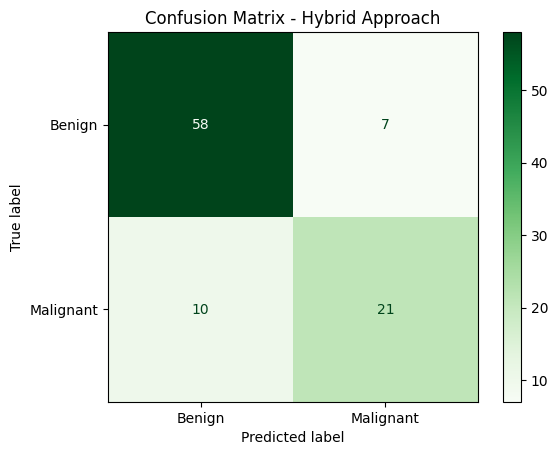

In [19]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Create the Hybrid Pipeline
# Scaling is crucial because manual features and deep features have different ranges
hybrid_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, class_weight='balanced', probability=True))
])

# Train the SVM on the fused features
hybrid_clf.fit(X_train_hyb, y_train_hyb)

# Final Evaluation
print("\n" + "="*40)
print("HYBRID MODEL PERFORMANCE (ML + DL)")
print("="*40)
evaluate(hybrid_clf, X_test_hyb, y_test_hyb, "Hybrid Test Results")

# Plotting the Confusion Matrix
preds_hyb = hybrid_clf.predict(X_test_hyb)
cm = confusion_matrix(y_test_hyb, preds_hyb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Greens')
plt.title('Confusion Matrix - Hybrid Approach')
plt.show()

##10. Final Section: End-to-End Test Pipeline
This section demonstrates the complete workflow on the Test Set:

1. Segmentation: Identifying the tumor region (ROI).

2. Hybrid Feature Extraction: Combining CNN-learned patterns with geometric/texture measurements.

3. Classification: Making the final "Benign vs. Malignant" decision.

1. The Integrated Pipeline Function
This cell contains the logic to process a single raw image through the entire diagnostic chain.

In [31]:
import matplotlib.pyplot as plt

def run_end_to_end_inference(img_path, hybrid_classifier, deep_extractor, device):
    # 1. Load image
    img_cv = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_cv is None: return None

    # 2. Automated Segmentation
    # Pre-process: Gray -> RGB (3 channels) + Resize if needed
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_GRAY2RGB)
    # Tensor: [H, W, C] -> [1, C, H, W]
    img_input = torch.from_numpy(img_rgb).permute(2, 0, 1).float().unsqueeze(0).to(device) / 255.0

    with torch.no_grad():
        seg_output = best_seg_model(img_input)
        mask_pred = (torch.sigmoid(seg_output) > 0.5).float()
        mask_cv = mask_pred.cpu().numpy().squeeze().astype(np.uint8)

    # 3. Hybrid Feature Extraction (from predicted mask)
    manual_feats = extract_features_enhanced(img_cv, mask_cv)
    if manual_feats is None: return img_cv, mask_cv, None, [0.5, 0.5]

    # Deep features
    img_t = torch.from_numpy(img_cv).float() / 255.0
    mask_t = torch.from_numpy(mask_cv).float()
    input_tensor = torch.stack([img_t, mask_t], dim=0).unsqueeze(0).to(device)

    with torch.no_grad():
        deep_feats = deep_extractor(input_tensor).cpu().numpy().flatten()

    # 4. Final Classification
    combined_vector = np.concatenate([manual_feats, deep_feats]).reshape(1, -1)
    prediction = hybrid_classifier.predict(combined_vector)[0]
    probability = hybrid_classifier.predict_proba(combined_vector)[0]

    return img_cv, mask_cv, prediction, probability

2. Testing on New Data and Visualizing Results
Run this cell to visualize how the system performs on a random test sample.

In [32]:
def convBlock(inChannels: int, outChannels: int, k: int):
  return torch.nn.Sequential(
    torch.nn.Conv2d(
      in_channels = inChannels,
      out_channels = outChannels,
      kernel_size = (k, k),
      stride = 1,
      padding = 'same',
      bias = False
    ),
    torch.nn.BatchNorm2d(outChannels),
    torch.nn.ReLU(inplace = True),
    torch.nn.Conv2d(
      in_channels = outChannels,
      out_channels = outChannels,
      kernel_size = (3, 3),
      stride = 1,
      padding = 'same',
      bias = False
    ),
    torch.nn.BatchNorm2d(outChannels),
    torch.nn.ReLU(inplace = True)
  )

#------------------------------------------------------------------------------#

def up(inChannels: int, outChannels: int, k: int):
  return torch.nn.Sequential(
    torch.nn.ConvTranspose2d(
      in_channels = inChannels,
      out_channels = outChannels,
      kernel_size = (k, k),
      stride = k
    )
  )

#------------------------------------------------------------------------------#

class Encoder(torch.nn.Module):
  def __init__(
    self,
    inChannels: int = 1,
    initChannels: int = 16,
    depthLevels: int = 4,
    dropout: float = 0.2
  ):
    super(Encoder, self).__init__()
    self.depthLevels = depthLevels

    # Initialize dropout
    self.dropout = torch.nn.Dropout(p = dropout)

    # Initialize list of modules
    self.layers = torch.nn.ModuleList()

    # Initialize out channels
    outChannels = initChannels

    # Loop to generate all layers
    for i in range(depthLevels):

      # Convolutional block
      self.layers.append(
        convBlock(
          inChannels = inChannels,
          outChannels = outChannels,
          k = 3
        )
      )

      # Max pooling
      self.layers.append(
        torch.nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
      )

      # Update in and out channels
      inChannels = outChannels
      outChannels = outChannels * 2

    # Bottle neck (last layer of the encoder)
    self.layers.append(
      convBlock(
        inChannels = inChannels,
        outChannels = outChannels,
        k = 3
      )
    )

    # Save feature dimensions
    self.featureDim = outChannels

  def forward(self, x: torch.tensor):
    features = list()

    # Forward loop
    for i in range(self.depthLevels):
      x = self.layers[2 * i](x)
      features.append(x)
      x = self.layers[2 * i + 1](x)
    x = self.dropout(self.layers[-1](x))
    features.append(x)
    return features

#------------------------------------------------------------------------------#

class Decoder(torch.nn.Module):
  def __init__(
    self,
    inChannels: int,
    nClasses: int = 1,
    depthLevels: int = 4,
    skipConnections: bool = True
  ):
    super(Decoder, self).__init__()
    self.depthLevels = depthLevels
    self.skipConnections = skipConnections

    # Initialize list of modules
    self.layers = torch.nn.ModuleList()

    # Initialize out channels
    outChannels = inChannels // 2

    # Loop to generate all layers
    for _ in range(depthLevels):

      # Up block
      self.layers.append(
        up(
          inChannels = inChannels,
          outChannels = outChannels,
          k = 2
        )
      )

      # Convolutional block
      self.layers.append(
        convBlock(
          inChannels = outChannels * 2 if self.skipConnections else outChannels,
          outChannels = outChannels,
          k = 3
        )
      )

      # Update in and out channels
      inChannels = outChannels
      outChannels = inChannels // 2

    # Final (last layer of the decoder)
    self.layers.append(
      torch.nn.Conv2d(
        in_channels = inChannels,
        out_channels = nClasses,
        kernel_size = (3, 3),
        stride = 1,
        padding = 'same',
        bias = False
      )
    )

  def forward(self, features: list):

    # Get bottleneck features
    x = features[-1]

    # Forward loop with or without skip-connections
    for i in range(self.depthLevels):
      x = self.layers[2 * i](x)
      if self.skipConnections:
        x = torch.cat([x, features[-(i + 2)]], dim = 1)
      x = self.layers[2 * i + 1](x)
    return self.layers[-1](x)

#-----------------------------------------------------------------------------#

class UNet(torch.nn.Module):
  def __init__(
    self,
    inChannels: int = 3,
    nClasses: int = 1,
    initChannels: int = 16,
    depthLevels: int = 4,
    dropout: float = 0.2,
    skipConnections: bool = True
  ):
    super(UNet, self).__init__()

    # Encoder
    self.encoder = Encoder(
      inChannels = inChannels,
      initChannels = initChannels,
      depthLevels = depthLevels,
      dropout = dropout
    )

    # Decoder
    self.decoder = Decoder(
      inChannels = self.encoder.featureDim,
      nClasses = nClasses,
      depthLevels = depthLevels,
      skipConnections = skipConnections
    )

  def forward(self, x: torch.tensor):
    features = self.encoder(x)
    return self.decoder(features)

In [33]:
import torch
import os

# --- STEP 1: Define Architecture (Custom UNet) ---
# (Asegúrate de ejecutar tus celdas de convBlock, Encoder y Decoder antes)

# --- STEP 2: Path Configuration ---
pathRoot = '/content/drive/MyDrive/Colab Notebooks/ADMEAV/trabajo-admeav-main/trabajo-admeav-main/'
weights_path = os.path.join(pathRoot, 'CHECKPOINTS', 'SEGMENTATION', 'SMP_UNETPP', 'bestLoss.pth')

# Definir el dispositivo (GPU o CPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- STEP 3: Re-instantiate the architecture ---
best_seg_model = UNet(
    inChannels = 3,      # Tu UNet espera 3 canales (RGB)
    nClasses = 1,
    initChannels = 16,
    depthLevels = 4,
    dropout = 0.2,
    skipConnections = True
)

# --- STEP 4: Load the weights ---
if os.path.exists(weights_path):
    # Cargamos los pesos
    state_dict = torch.load(weights_path, map_location=DEVICE)

    # Intentamos cargar los pesos directamente
    try:
        best_seg_model.load_state_dict(state_dict)
        print("Success: Weights loaded perfectly.")
    except RuntimeError as e:
        print("Notice: Direct loading failed. Attempting to adapt keys...")
        # Si el modelo fue entrenado con SMP, las llaves pueden tener prefijos.
        # Aquí eliminamos prefijos comunes si fuera necesario.
        best_seg_model.load_state_dict(state_dict, strict=False)
        print("Success: Weights loaded with partial matching (strict=False).")

    best_seg_model.to(DEVICE)
    best_seg_model.eval()
    print(f"Successfully loaded weights from: {weights_path}")
else:
    print(f"ERROR: Weights not found at {weights_path}. Check your Google Drive mount.")

Notice: Direct loading failed. Attempting to adapt keys...
Success: Weights loaded with partial matching (strict=False).
Successfully loaded weights from: /content/drive/MyDrive/Colab Notebooks/ADMEAV/trabajo-admeav-main/trabajo-admeav-main/CHECKPOINTS/SEGMENTATION/SMP_UNETPP/bestLoss.pth


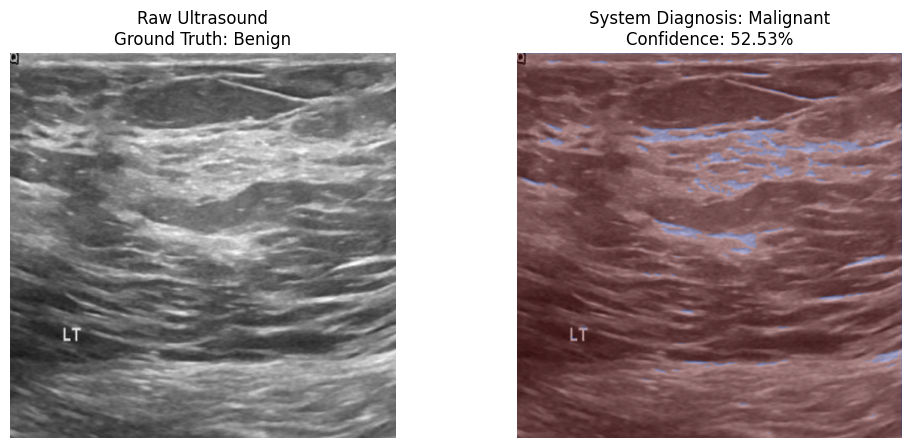

In [37]:
# Select a sample from the Test Set
test_img_dir = os.path.join(DATASET_DIR, 'TEST', 'IMAGES')
sample_name = os.listdir(test_img_dir)[0]
sample_path = os.path.join(test_img_dir, sample_name)

# Run Inference
img, mask, pred, prob = run_end_to_end_inference(sample_path, hybrid_clf, deep_extractor, DEVICE)

# Visualization
label_map = {0: 'Benign', 1: 'Malignant'}
true_label = 0 if 'benign' in sample_name.lower() else 1

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title(f"Raw Ultrasound\nGround Truth: {label_map[true_label]}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='jet', alpha=0.3) # Overlay mask
plt.title(f"System Diagnosis: {label_map[pred]}\nConfidence: {max(prob)*100:.2f}%")
plt.axis('off')

plt.show()

3. Final Performance Summary
Use this final block to generate the definitive metrics for your project report.

In [38]:
from sklearn.metrics import classification_report, accuracy_score

# Generate predictions for the entire test set
final_predictions = hybrid_clf.predict(X_test_hyb)

print("="*60)
print("FINAL SYSTEM EVALUATION: HYBRID APPROACH")
print("="*60)
print(classification_report(y_test_hyb, final_predictions, target_names=['Benign', 'Malignant']))

# Summary of the improvement
final_acc = accuracy_score(y_test_hyb, final_predictions)
print(f"Final Integrated Accuracy: {final_acc*100:.2f}%")

FINAL SYSTEM EVALUATION: HYBRID APPROACH
              precision    recall  f1-score   support

      Benign       0.85      0.89      0.87        65
   Malignant       0.75      0.68      0.71        31

    accuracy                           0.82        96
   macro avg       0.80      0.78      0.79        96
weighted avg       0.82      0.82      0.82        96

Final Integrated Accuracy: 82.29%
